In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

FileNotFoundError: [Errno 2] No such file or directory: './data'

In [3]:
os.chdir("/n/fs/cyc424/sjayanti/final-proj-cos-424/data")
arg_k = np.arange(2,10)

highest= {} 
for estimate in ('mle', 'argmax'):
    best_k_r2 = -np.inf, None
    for epsilon in ('eps', '0.001', '0.1'):
        for k in arg_k:
            filename = 'cv-'+str(k)+'-'+estimate+'-'+epsilon+'.p_r2.npy'
            if not os.path.isfile(filename): continue
            mean = np.mean(np.load(filename))
            best_k_r2 = max(best_k_r2, (mean, k, epsilon))
    highest[estimate] = best_k_r2
for k, v in highest.items():
    mean, best_k, epsilon = v
    ls = []
    for K in arg_k:
        filename = 'cv-'+str(K)+'-'+k+'-'+epsilon+'.p_r2.npy'
        if not os.path.isfile(filename): continue
        mean = np.mean(np.load(filename))
        ls.append((K, mean))
    Ks, means = zip(*ls)
    Ks, means = np.array(Ks), np.array(means)
    print('Epsilon for', k, '=', epsilon, '; best K =', best_k, '; mean =', mean)
    highest[k] = (Ks, means)
        
highest

Epsilon for mle = 0.001 ; best K = 6 ; mean = 0.516839386894
Epsilon for argmax = 0.1 ; best K = 5 ; mean = 0.541648961757


{'argmax': (array([2, 3, 4, 5, 6, 7, 8, 9]),
  array([ 0.31774482,  0.43718584,  0.47655626,  0.56735432,  0.48081392,
          0.50058621,  0.50331297,  0.54164896])),
 'mle': (array([2, 3, 4, 5, 6, 8]),
  array([ 0.16769272,  0.25159341,  0.45385338,  0.48479414,  0.53806716,
          0.51683939]))}

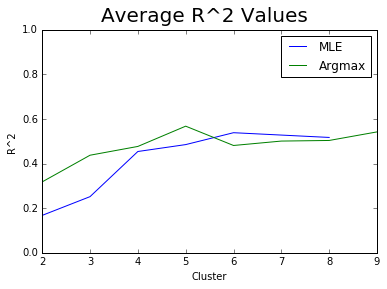

In [4]:
K = 9
N = 33
D = 350000

def plotR2(r2dict):
    mles = r2dict['mle'][1]
    amxs = r2dict['argmax'][1]
    Km = r2dict['mle'][0]
    Ka = r2dict['argmax'][0]

    plt.plot(Km, mles, label='MLE')
    plt.plot(Ka, amxs, label='Argmax')
    plt.suptitle('Average R^2 Values', fontsize=20)
    plt.ylabel('R^2')
    plt.xlabel('Cluster')
    plt.legend()
    plt.axis([2,9,0,1])
    plt.show()
    
R2vecMLE =  np.random.normal(0.2,0.1, size=(K,N))
R2vecARGMAX =  np.random.normal(0.2,0.1, size=(K,N))
resp = np.random.normal(0.2,0.01,size=(K,N))
plotR2(highest)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
   0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 1.  1.  1.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  1.  1.  1.  0.
   1.  1.  1.  1.  1.  1.  1.  0.  0.  1.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.]]


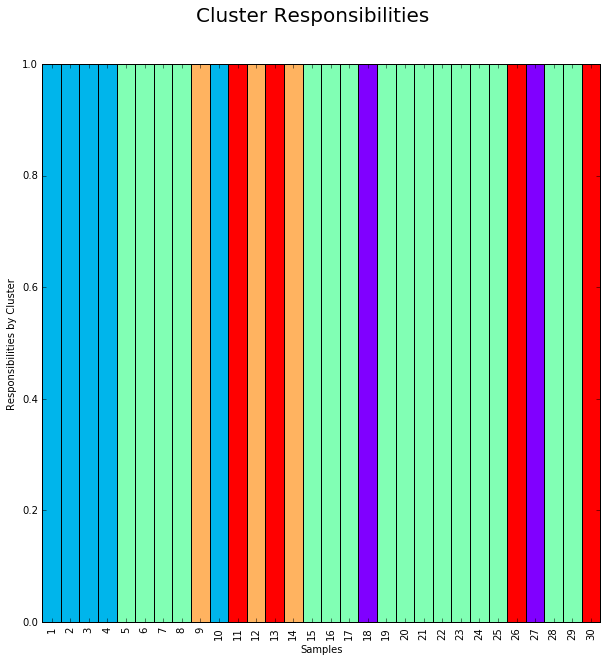

In [11]:
def plotbar(resp):
    f = plt.figure(figsize=(10,10))
    K = resp.shape[0]
    N = resp.shape[1]

    sample_interval = [i for i in range(N)]
    running_sum = np.zeros(N)
    color_vec = plt.cm.rainbow(np.linspace(0, 1, K))
    for i in range(resp.shape[0]):
        plt.bar(sample_interval, resp[i,:], width=1.0, color = color_vec[i], bottom = running_sum)
        running_sum = running_sum + resp[i,:]
    plt.suptitle('Cluster Responsibilities', fontsize=20)
    plt.ylabel('Responsibilities by Cluster')
    plt.xlabel('Samples')
    plt.axis([0,N,0,1])
    #plt.legend(handles=[mplot, aplot])
    x = [i+0.5 for i in range(N)]
    labels = [i+1 for i in range(N)]
    plt.xticks(x, labels, rotation='vertical')
    plt.show()

os.chdir("/n/fs/cyc424/sjayanti/final-proj-cos-424")
all_alphas = np.load("all_alphas.npy")
alphas = np.exp(all_alphas)
print(alphas)
plotbar(alphas)

In [12]:
def KL(mu1, mu2, sigma1, sigma2):
    detS1 = np.prod(sigma1)
    detS2 = np.prod(sigma2)

    d = len(mu1)
    
    invS2 = [1/x for x in sigma2]
    trInvS2S1 = np.sum([x1*x2 for x1, x2 in zip(invS2, sigma1)])
    
    mu2MinusMu1 = [x-y for x,y in zip(mu2,mu1)]
    lastTerm = np.sum([x1*x2*x3 for x1, x2, x3 in zip(mu2MinusMu1, invS2, mu2MinusMu1)])
    
    kl = (1/2)*(np.log(detS2/detS1) - d + trInvS2S1 + lastTerm)
    return kl
    
def sym_KL(mu1, mu2, sigma1, sigma2):
    kl1 = KL(mu1, mu2, sigma1, sigma2)
    kl2 = KL(mu2, mu1, sigma2, sigma1)
    return kl1 + kl2
    
print(KL([1,1],[0,0],[1,1],[1,1]))
print(sym_KL([1,1],[0,0],[1,1],[1,1]))

1.0
2.0


[[0.0, 283.54474922535792, 356.81274848428473, 324.19882404133921, 392.92618464879479], [283.54474922535792, 0.0, 344.16272063919462, 303.312036354143, 402.87105102408344], [356.81274848428473, 344.16272063919462, 0.0, 389.12869153500549, 363.95770487450096], [324.19882404133921, 303.312036354143, 389.12869153500549, 0.0, 402.23968841629022], [392.92618464879479, 402.87105102408344, 363.95770487450096, 402.23968841629022, 0.0]]


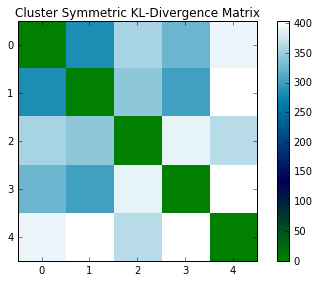

In [16]:
def plot_KL(mu, sigma):
    K = len(mu)
    kl_mat = [[sym_KL(mu[i], mu[j], sigma[i], sigma[j]) for i in range(K)] for j in range(K)]
    print(kl_mat)
    plt.imshow(kl_mat, interpolation='nearest', cmap=plt.cm.ocean)
    plt.title('Cluster Symmetric KL-Divergence Matrix')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

K = 5
N = 100
mus = [np.random.normal(0,3, size=(N)) for i in range(K)]
sigmas = [np.random.normal(5, 1, size=(N)) for i in range(K)]

plot_KL(mus, sigmas)